In [25]:
import os
import re
import random
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score



def visualize_training_progress(proj_dir, run_dir, only_image_num=None):
    logging_dir = '/scratch/users/austin.zane/ucsf_fast/logging/'
    image_dir = os.path.join(logging_dir, proj_dir, run_dir, 'segmentation_overlays')
    file_names = os.listdir(image_dir)
    image_groups = {}

    for file_name in file_names:
        match = re.match(r'epoch_(\d+)_batch_(\d+)_image_(\d+)\.(\w+)', file_name)
        if match:
            epoch, batch, image_num, extension = match.groups()
            if extension == 'png':  # Only consider files with .png extension
                if image_num not in image_groups:
                    image_groups[image_num] = []
                image_groups[image_num].append((int(epoch), int(batch), file_name))

    if len(image_groups) == 0:
        print('No images found')

    # Print file names in order by epoch and then by batch for each image
    for image_num, files in image_groups.items():
        if only_image_num is not None and image_num != str(only_image_num):
            continue

        print(f"#################\n#### Image {image_num} ####\n#################")
        files.sort()  # Sort files by epoch and then by batch

        # Initialize a counter to keep track of the image index
        image_index = 0

        for epoch, batch, file_name in files:
            if image_index % 4 == 0:  # Print every other image
                print(f'Epoch: {epoch}')
                print(f'File name: {file_name}')
                img = Image.open(os.path.join(image_dir, file_name))
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.imshow(img)
                ax.axis('off')
                plt.show()
                print()

            # Increment the image index
            image_index += 1
            

def vis_input_classification_images(proj_name, run_name):
    image_dir = os.path.join('/scratch/users/austin.zane/ucsf_fast/data/class_outputs/', proj_name, run_name, 'raw')
    raw_files = os.listdir(image_dir)
    image_fnames = [f for f in raw_files if f.startswith('img')]
    labels = np.load(os.path.join(image_dir, 'labels.npy'))
    print(labels)
                     
    for fname in image_fnames:
        img = np.load(os.path.join(image_dir, fname))
        img = (img + 1) / 2
        
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
        plt.show()
    
    
def load_vectors(proj_name, run_name, split):
    class_output_dir = '/scratch/users/austin.zane/ucsf_fast/data/class_outputs/'
    run_split_dir = os.path.join(class_output_dir, proj_name, run_name, split)
    label_pairs_path = os.path.join(run_split_dir, 'pred_and_true_labels.npy')
    
    label_pairs = np.load(label_pairs_path)
    
    pred_labels = label_pairs[:, 0]
    true_labels = label_pairs[:, 1]
        
    return true_labels, pred_labels, label_pairs
    


def calculate_statistics(true_labels, predicted_probs, threshold=0.5):
    """
    Calculate various statistics given true labels and predicted probabilities.

    Args:
        true_labels (numpy.ndarray): True binary labels.
        predicted_probs (numpy.ndarray): Predicted probabilities.
        threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
        dict: Dictionary containing the calculated statistics.
    """
    label_ratio = sum(true_labels) / len(true_labels)
    pred_ratio = sum(predicted_probs) / len(predicted_probs)
    
    
    
    # Convert predicted probabilities to binary predictions
    predicted_labels = (predicted_probs >= threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    # print(cm)
    # print(f'TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}')

    # Calculate statistics
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    # auc = roc_auc_score(true_labels, predicted_probs)

    # Create a dictionary to store the statistics
    statistics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Positive Predictive Value': ppv,
        'Negative Predictive Value': npv,
        # 'Precision': precision,
        # 'Recall': recall,
        'Accuracy': accuracy,
         # 'AUC': auc
        'True label ratio': label_ratio,
        'Pred label ratio': pred_ratio,
    }

    return statistics


def find_optimal_threshold(true_labels, predicted_probs, metric='accuracy'):
    """
    Find the optimal threshold for a given metric.

    Args:
        true_labels (numpy.ndarray): True binary labels.
        predicted_probs (numpy.ndarray): Predicted probabilities.
        metric (str): The metric to optimize ('accuracy', 'sensitivity', 'specificity', etc.).

    Returns:
        float: The optimal threshold.
        dict: The statistics for the optimal threshold.
    """
    thresholds = np.arange(0.0, 1.0, 0.01)
    optimal_threshold = 0.0
    optimal_statistics = None
    best_metric_value = -np.inf

    for threshold in thresholds:
        statistics = calculate_statistics(true_labels, predicted_probs, threshold)
        metric_value = statistics[metric.capitalize()]

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            optimal_threshold = threshold
            optimal_statistics = statistics

    return optimal_threshold, optimal_statistics

### Positive sets
* Num of pos train frames: 343
* Num of pos vali. frames: 112
* Num of pos test frames: 302
### Negative sets
* Num of neg train frames: 194
* Num of neg vali. frames: 95
* Num of neg test frames: 190
### Total
* Train frames: 537
* Validation frames: 207
* Test frames: 492

#################
#### Image 2 ####
#################
Epoch: 4
File name: epoch_4_batch_53_image_2.png


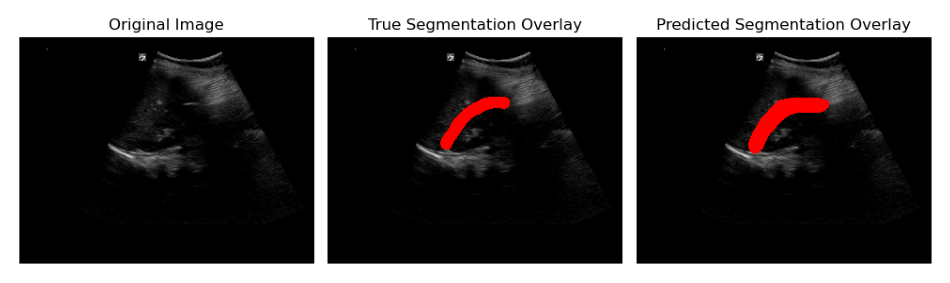


Epoch: 24
File name: epoch_24_batch_53_image_2.png


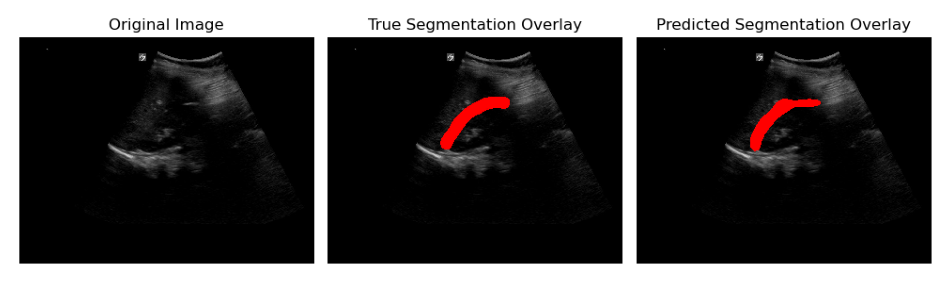


Epoch: 44
File name: epoch_44_batch_53_image_2.png


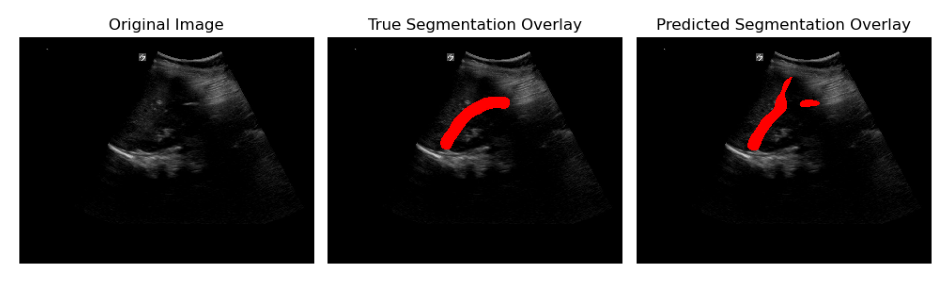


Epoch: 64
File name: epoch_64_batch_53_image_2.png


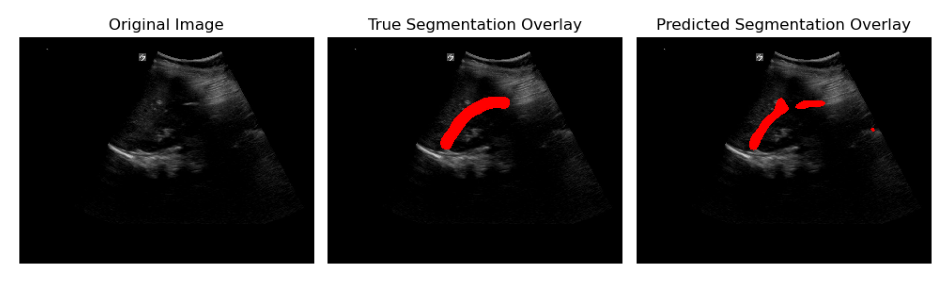


Epoch: 84
File name: epoch_84_batch_53_image_2.png


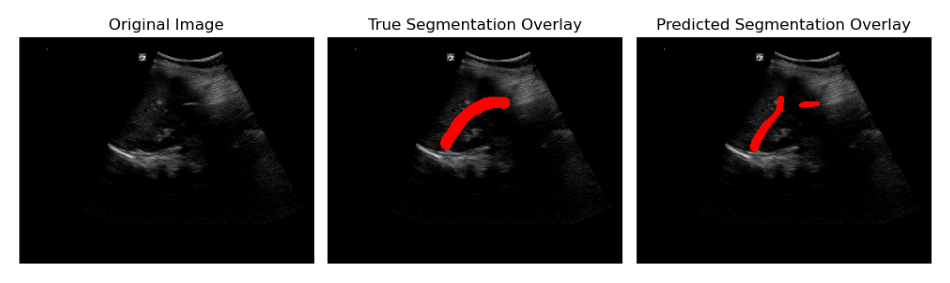

In [27]:
visualize_training_progress('unet_test_05_18_24', 'scarlet-water-11-2l4vc76j', 2)

[[0.]
 [1.]]


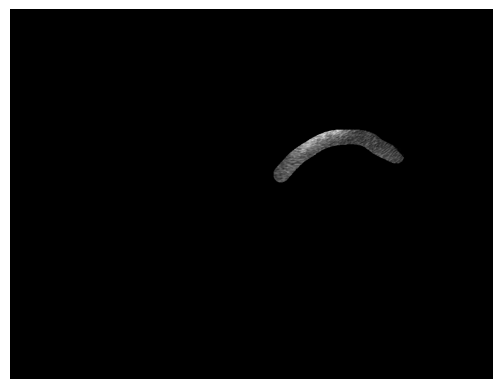

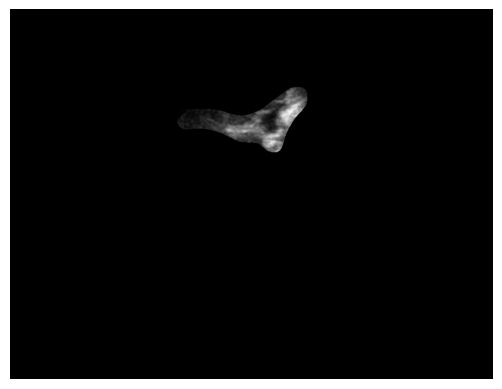

In [10]:
proj_name = 'resnet_test_05_19_24'
run_name = 'playful-snow-11-mi8nhp9v'

vis_input_classification_images(proj_name, run_name)

In [17]:
# Loss weight 10

proj_name = 'resnet_test_05_20_24'
run_name = 'crimson-brook-1-dbbh1lmz'
split = 'val'

true_labels, predicted_probs, label_pairs = load_vectors(proj_name, run_name, split)
stats = calculate_statistics(true_labels, predicted_probs, threshold=0.5)

# Print the statistics
for metric, value in stats.items():
    print(f'{metric}: {value:.3f}')

Sensitivity: 0.125
Specificity: 0.874
Positive Predictive Value: 0.538
Negative Predictive Value: 0.459
Accuracy: 0.469
True label ratio: 0.541
Pred label ratio: 0.125


In [18]:
# Loss weight 20

proj_name = 'resnet_test_05_20_24'
run_name = 'stoic-surf-2-b2p4lr0g'
split = 'val'

true_labels, predicted_probs, label_pairs = load_vectors(proj_name, run_name, split)
stats = calculate_statistics(true_labels, predicted_probs, threshold=0.5)

# Print the statistics
for metric, value in stats.items():
    print(f'{metric}: {value:.3f}')

Sensitivity: 0.071
Specificity: 0.747
Positive Predictive Value: 0.250
Negative Predictive Value: 0.406
Accuracy: 0.382
True label ratio: 0.541
Pred label ratio: 0.153
